In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from astropy.io import fits
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval,SqrtStretch,ZScaleInterval,PercentileInterval,ImageNormalize)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from itertools import repeat
from matplotlib.colors import LogNorm
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import norm
import pickle
from tools.equivalentWidth import *
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.interpolate import interp1d
from libradtranpy import libsimulateVisible
import subprocess

libradtranpath= /home/joseph/libRadtran/


# Now we condense the whole process and iterate on dates

In [2]:
############################################
## Initialise data and formatting options ##
##      May be improved or automated      ##
############################################
inputdir = '../../AuxTelComm/notebookccdm_gen3/bouguerlines/2022_09/data/'
#inputdir = '../data/2022/'
file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1D.pickle' #ou PSF2DFFM ou PSF2D
#file_label = 'run-auxtel-holo-{0}-{1}~{2}-config_DECONVOLUTION_PSF1DvNov2022jocheval.pickle' #ou PSF2DFFM ou PSF2D
outdir = './output_files/'


bad_spec_dict = {'20220628':[171,223,250,251,400,425,479,480,538,593,654,655,656,657,683,708],
                 '20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593]}


'''
bad_spec_dict = {'20220629':[206,304,305,418,420,451,504],
                 '20220630':[50,126,181,182,220,356,410,440,454,455,480,525,566,593, 594]}
'''
'''
bad_spec_dict = {'20211103':[449, 450, 451, 455, 552, 565, 730, 742]}
'''
if not os.path.exists(outdir):
    os.mkdir(outdir)

obs_dates = bad_spec_dict.keys() #np.array(['20220628', '20220629', '20220630'])
filter_ = 'FELH0600'
disperser = 'holo4_003'
save_txt = True

markerCols = ['green', 'blue', 'red']
errbarCols = ['limegreen', 'cyan', 'magenta']
markerStyle = ['x', 'o', 'v']

abs_min, abs_max = 700.0, 800.0

In [3]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(12,6)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 
os.getenv('LIBRADTRANDIR')

'/home/joseph/libRadtran'

In [4]:
AMMIN=1
AMMAX=2.3
AMSTEP = 0.1
all_am=np.arange(AMMIN,AMMAX,AMSTEP)
pressure = 0. # use default value
all_pwv=np.arange(0.0, 5., 0.5)
aer=0
ozone=300.
cloudext=0
atmStd='mw'
NBOBS=len(all_am)
NBPWM=len(all_pwv)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange( NBOBS), alpha=1)

In [5]:
if True:
    all_trans = []
    libsimulateVisible.Mod = 'lt'
    for index in np.arange(NBOBS):
        am = all_am[index]
        print("simulate index=",index," airmass = ",am)
        path,thefile=libsimulateVisible.ProcessSimulation(am,all_pwv[1],ozone,pressure,
                                                          prof_str=atmStd,proc_str='sa',cloudext=cloudext)
        data = np.loadtxt(os.path.join(path[0],thefile[0]))
        wl = data[:,0]
        atm = data[:,1] 
        all_trans.append(atm)

simulate index= 0  airmass =  1.0
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z10_wv5_oz30_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z10_wv5_oz30_cld0000.OUT
simulate index= 1  airmass =  1.1
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z11_wv5_oz30_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z11_wv5_oz30_cld0000.OUT
simulate index= 2  airmass =  1.2000000000000002
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z12_wv5_oz30_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z12_wv5_oz30_cld0000.OUT
simulate index= 3  airmass =  1.3000000000000003
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z13_wv5_oz30_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS

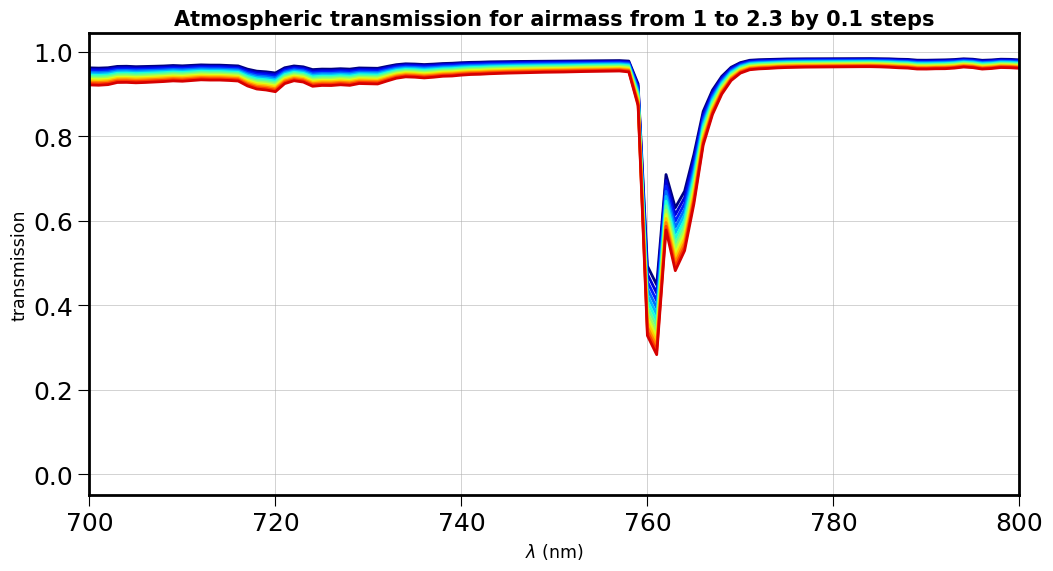

In [6]:
if True:
    for index in np.arange(NBOBS):   
        plt.plot(wl,all_trans[index],'-',color=all_colors[index])
    plt.xlim(300,1200)
    plt.grid()
    plt.title(f"Atmospheric transmission for airmass from {AMMIN} to {AMMAX} by {AMSTEP} steps")
    plt.xlabel("$\\lambda$ (nm)")
    plt.ylabel("transmission")
    #plt.ylim(0.5,1)
    plt.xlim(700.,800.)
    figname="multitransmission.png"
    plt.savefig(figname)

In [7]:
#########################################    
## Run everything and iterate on dates ##
#########################################

maxSigma = 0.
refO2 = 760.
gaussMod, gaussCov = np.empty_like([]), np.empty_like([])
borneInf_cont, borneInf_band, borneSup_band, borneSup_cont = refO2, refO2, refO2, refO2

for obs_date in obs_dates:
    inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
    with open(inputfile,'rb') as f:
        spec_dict = pickle.load(f)
    
    bad_spec = bad_spec_dict[obs_date]

    spec_dict_good = {}
    for key in spec_dict.keys():
        if int(spec_dict[key]['number']) not in bad_spec:
            spec_dict_good[key] = spec_dict[key]
            
    for spec in spec_dict_good:
        print(spec_dict_good[spec]['number'])
        
        lambda_ = spec_dict_good[spec]['all_lambdas']
        flux_ = spec_dict_good[spec]['all_fluxes']
        flux_err_ = spec_dict_good[spec]['all_fluxes_err']
        
        gaussMod_, cov, lims_ = fit_gaussian(lambda_, flux_, abs_min, abs_max, sigma_flux=flux_err_, central_lambda=refO2)
        if gaussMod_[3] > maxSigma:
            maxSigma = gaussMod_[3]
            refO2 = gaussMod_[2]
            gaussMod = gaussMod_
            gaussCov = cov
            print("Widest band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[0] < borneInf_cont:
            borneInf_cont = lims_[0]
            print("Lower limit for continuum identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[1] < borneInf_band:
            borneInf_band = lims_[1]
            print("Lower limit for band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[2] > borneSup_band:
            borneSup_band = lims_[2]
            print("Upper limit for band identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        if lims_[3] > borneSup_cont:
            borneSup_cont = lims_[3]
            print("Upper limit for continuum identified for exposure No. {:.0f}, std {}, air mass={:.4f}".format(spec_dict_good[spec]['number'], spec_dict_good[spec]['object'], spec_dict_good[spec]['airmass']))
        lims = np.array([borneInf_cont, borneInf_band, borneSup_band, borneSup_cont])
print(lims, refO2)

143.0
Widest band identified for exposure No. 143, std HD142331, air mass=1.0905
Lower limit for continuum identified for exposure No. 143, std HD142331, air mass=1.0905
Lower limit for band identified for exposure No. 143, std HD142331, air mass=1.0905
Upper limit for band identified for exposure No. 143, std HD142331, air mass=1.0905
Upper limit for continuum identified for exposure No. 143, std HD142331, air mass=1.0905
144.0
Widest band identified for exposure No. 144, std HD142331, air mass=1.0900
Upper limit for band identified for exposure No. 144, std HD142331, air mass=1.0900
Upper limit for continuum identified for exposure No. 144, std HD142331, air mass=1.0900
145.0
Widest band identified for exposure No. 145, std HD142331, air mass=1.0894
Lower limit for continuum identified for exposure No. 145, std HD142331, air mass=1.0894
Lower limit for band identified for exposure No. 145, std HD142331, air mass=1.0894
169.0
Widest band identified for exposure No. 169, std HD142331, 

Text(0.5, 0.98, 'Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit')

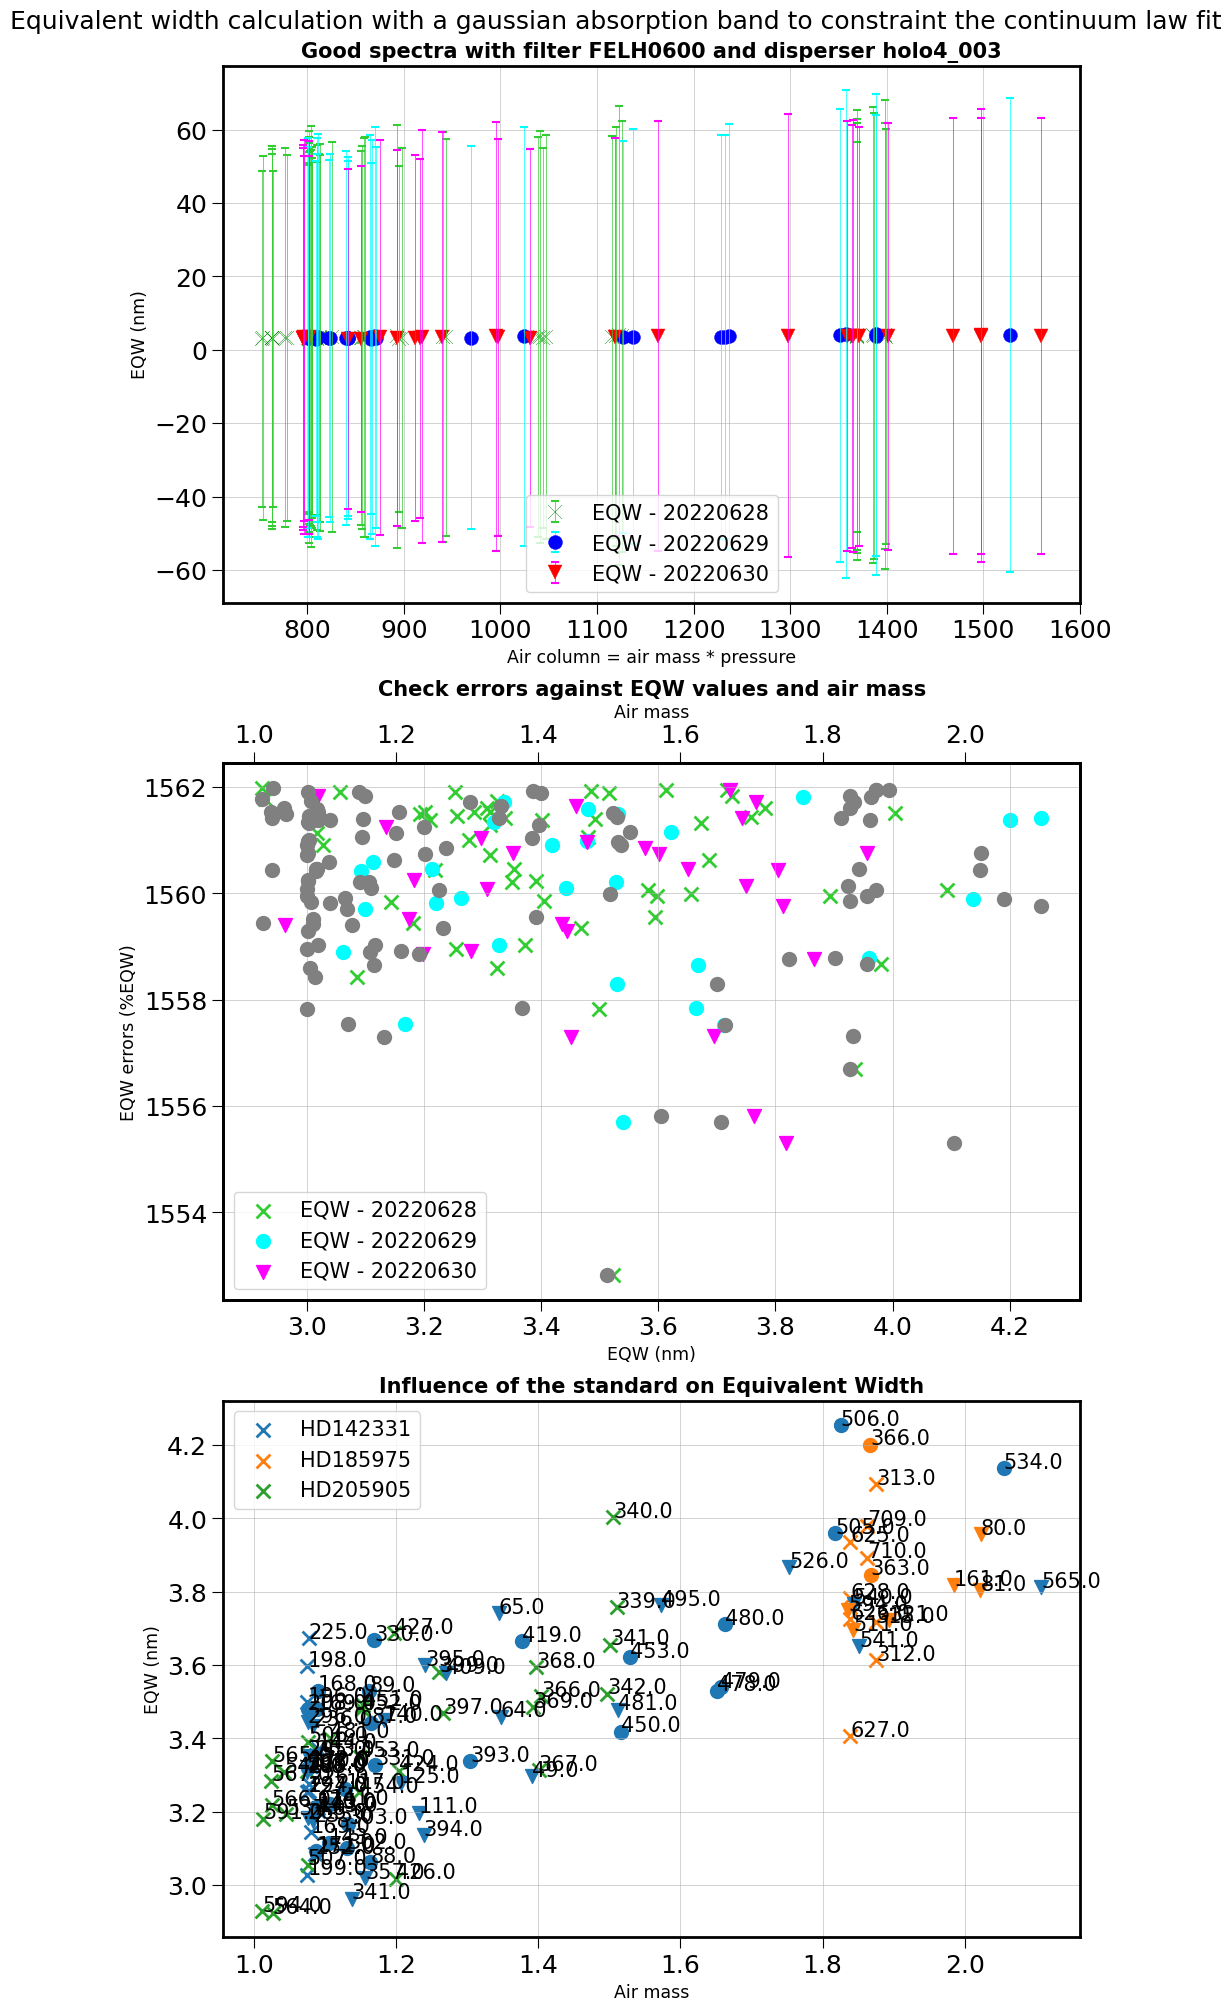

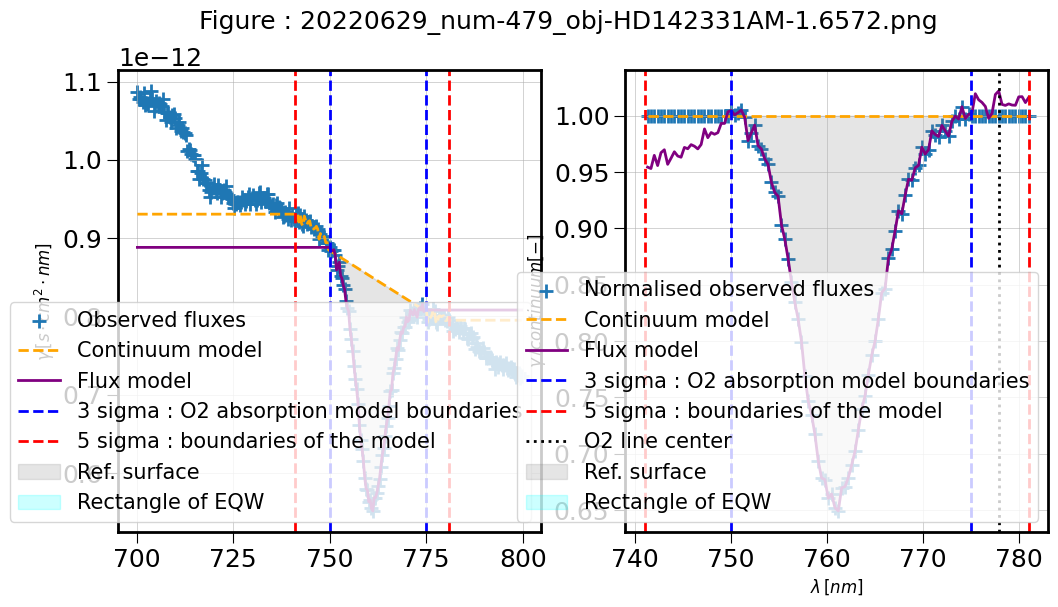

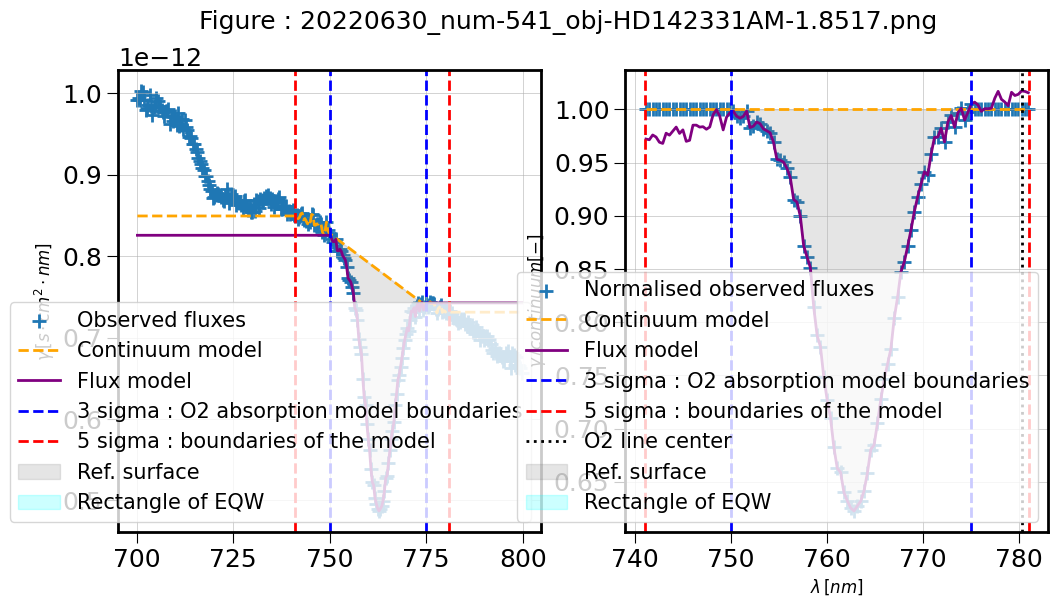

In [8]:
if True:
    lims = np.array([741., 750., 775., 781.])
    ref_band = 761.
    gaussMod[2] = ref_band

fig, axs = plt.subplots(3, 1, figsize=(10,20), constrained_layout=True)
axs = axs.ravel()

all_airmasses = np.empty_like([])
all_pressures = np.empty_like([])
all_eqws = np.empty_like([])
all_eqwerrs = np.empty_like([])
all_area_c_errs = np.empty_like([])
all_cont_errs = np.empty_like([])
all_area_ul_errs = np.empty_like([])
all_area_l_errs = np.empty_like([])
all_numbers = np.empty_like([])
all_objects = np.empty_like([])

all_contFunc = np.empty_like([])
all_spectFunc = np.empty_like([])
targetList = []

abs_min = min(lims[0]-10, abs_min)
abs_max = max(lims[-1]+10, abs_max)
_loc=-1
for obs_date, mstyle, mcol, ecol in zip(obs_dates, markerStyle, markerCols, errbarCols):
    _loc += 1
    inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
    with open(inputfile,'rb') as f:
        spec_dict = pickle.load(f)
    
    bad_spec = bad_spec_dict[obs_date]

    spec_dict_good = {}
    for key in spec_dict.keys():
        if int(spec_dict[key]['number']) not in bad_spec:
            spec_dict_good[key] = spec_dict[key]

    #ref_obs = 'exposure_2022062800143_postisrccd_spectrum.fits'
    #lambda_ref = spec_dict_good[ref_obs]['all_lambdas']
    #flux_ref = spec_dict_good[ref_obs]['all_fluxes']

    airmass = np.empty_like([])
    pressure = np.empty_like([])
    eqwidths = np.empty_like([])
    eqw_errs = np.empty_like([])
    numbers = np.empty_like([])
    objects = np.empty_like([])
    loc=-1
    for spec in spec_dict_good:
        loc += 1
        airmass_ = spec_dict_good[spec]['airmass']
        pressure_ = spec_dict_good[spec]['pressure']
        lambda_ = spec_dict_good[spec]['all_lambdas']
        flux_ = spec_dict_good[spec]['all_fluxes']
        flux_err_ = spec_dict_good[spec]['all_fluxes_err']
        expNum_ = spec_dict_good[spec]['number']
        object_ = spec_dict_good[spec]['object']
        if not object_ in targetList:
            targetList.append(object_)

        '''
        if loc%10 == 0 :
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=True, return_fit=True, plot_name="{}_AM-{:.4f}.png".format(obs_date, airmass_))
        else:
            eqw_, eqw_err_, mod, cov, xline, fline, xcontinuum, cont_at_line, area_l_, area_c_err_ = eqw_norm(lambda_, flux_, abs_min, abs_max, make_plot=False, return_fit=True)
        '''
        
        #if loc%10 == 0 :
        if expNum_ in [479, 541]:
            eqw_, bandWidth, eqw_err_, spectrum, continuum, limits = eqw_norm(lambda_, flux_, abs_min, abs_max,\
                                                                              sigma_flux=flux_err_, gaussMod_band=gaussMod,\
                                                                              limits=lims, fit_band=False, make_plot=True,\
                                                                              return_fit=True,\
                                                                              plot_name="{}_num-{:.0f}_obj-{}AM-{:.4f}.png".format(obs_date, expNum_, object_, airmass_))
        else:
            eqw_, bandWidth, eqw_err_, spectrum, continuum, limits = eqw_norm(lambda_, flux_, abs_min, abs_max,\
                                                                              sigma_flux=flux_err_, gaussMod_band=gaussMod,\
                                                                              limits=lims, fit_band=False, make_plot=False,\
                                                                              return_fit=True)

        '''
        if eqwdb_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
            eqwdb_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        elif eqwdf_<0.:
            print(seqn)
            plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
            eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqw0.png'.format(seqn)
        eqw0_ = eqw(x_,flux0,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)

        plot_name_ = 'fit_line_{0}_eqwdf.png'.format(seqn)
        eqwdf_ = eqw(x_,fluxdf,xmask_c,xmin_int,xmax_int,xmin_line,make_plot=True,plot_name=plot_name_)
        '''
        
        airmass = np.append(airmass, airmass_)
        pressure = np.append(pressure, pressure_)
        eqwidths = np.append(eqwidths, eqw_)
        eqw_errs = np.append(eqw_errs, eqw_err_)
        numbers = np.append(numbers, expNum_)
        objects = np.append(objects, object_)
        
        all_airmasses = np.append(all_airmasses, airmass_)
        all_pressures = np.append(all_pressures, pressure_)
        all_eqws = np.append(all_eqws, eqw_)
        all_eqwerrs = np.append(all_eqwerrs, eqw_err_)
        #all_area_c_errs = np.append(all_area_c_errs, area_c_err)
        #all_cont_errs = np.append(all_cont_errs, cont_err_)
        #all_area_ul_errs = np.append(all_area_ul_errs, area_ul_err_)
        #all_area_l_errs = np.append(all_area_l_errs, area_l_err_)
        all_numbers = np.append(all_numbers, expNum_)
        all_objects = np.append(all_objects, object_)
        
        all_contFunc = np.append(all_contFunc, continuum)
        all_spectFunc = np.append(all_spectFunc, spectrum)
    if save_txt:
        data = np.transpose(np.array([numbers, airmass, pressure, eqwidths, eqw_errs]))
        np.savetxt(os.path.join(outdir,'eqw_data_{0}_{1}_{2}.txt'.format(obs_date, filter_, disperser)), data, header='id airmass pressure eqw eqw_err')
    
    targetList = np.array(targetList)
    axs[0].errorbar(airmass*pressure, eqwidths, yerr=eqw_errs, ls='', marker=mstyle, color=mcol, ecolor=ecol, elinewidth=.5, capsize=3, barsabove=True, capthick=1.5, label="EQW - {}".format(obs_date))
    axs[1].scatter(eqwidths, 100.*eqw_errs/eqwidths, marker=mstyle, color=ecol, label="EQW - {}".format(obs_date))
    for target,col in zip(targetList, ['tab:blue', 'tab:orange', 'tab:green']):
        if _loc == 0:
            axs[2].scatter(airmass[objects == target], eqwidths[objects == target], marker=mstyle, color=col, label=target)
        else:
            axs[2].scatter(airmass[objects == target], eqwidths[objects == target], marker=mstyle, color=col)

###################
# format the plot #
###################
axs[0].grid()
axs[0].set_xlabel("Air column = air mass * pressure")
axs[0].set_ylabel("EQW (nm)")
axs[0].set_title("Good spectra with filter {} and disperser {}".format(filter_, disperser))
axs[0].legend()

axs11=axs[1].twiny()
axs11.scatter(all_airmasses, 100.*all_eqwerrs/all_eqws, color="gray")
axs11.set_xlabel("Air mass")

axs[1].grid()
axs[1].set_ylabel("EQW errors (%EQW)")
axs[1].set_xlabel("EQW (nm)")
axs[1].set_title("Check errors against EQW values and air mass")
axs[1].legend()

for am, eqw, num in zip(all_airmasses, all_eqws, all_numbers):
    axs[2].text(am, eqw, num)
axs[2].grid()
axs[2].set_ylabel("EQW (nm)")
axs[2].set_xlabel("Air mass")
axs[2].set_title("Influence of the standard on Equivalent Width")
#axs[2].scatter(all_airmasses, np.power(all_eqwerrs, 2.), color="gray", label="total variance")
#axs[2].scatter(all_airmasses, np.power(all_area_l_errs, 2.), color="blue", label="from surface computation")
#axs[2].scatter(all_airmasses, np.power(all_cont_errs*all_eqws, 2.), color="red", label="from continuum estimation")
#axs[2].set_yscale('log')
#axs[2].grid()
#axs[2].set_ylabel("EQW errors (nm)")
#axs[2].set_xlabel("Air mass")
#axs[2].set_title("Check errors against air mass")
axs[2].legend()
fig.suptitle("Equivalent width calculation with a gaussian absorption band to constraint the continuum law fit")

# Attempt to compare to libradtran sim here

In [9]:
h2o_line=gaussMod[2]
print(h2o_line)
sigmaBand_=gaussMod[3]
min_wl, max_wl = abs_min, abs_max
limInf_cont, limInf_band, limSup_band, limSup_cont = h2o_line, h2o_line, h2o_line, h2o_line
gaussianMod, gaussianCov = gaussMod, gaussCov

761.0


In [10]:
ids, airmasses, pressures, eqwidths, eqw_errs = np.loadtxt(os.path.join(outdir,'eqw_data_20220629_FELH0600_holo4_003.txt'), skiprows=1, unpack=True)
print(len(ids))
gaussianLimits = lims #determined on observations
print(gaussianLimits)
print(min_wl, max_wl)

28
[741. 750. 775. 781.]
700.0 800.0


8 7 7 7
[0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3] [ 6 10  2  5  4  1  0]


/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/joseph/AuxtelEnv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


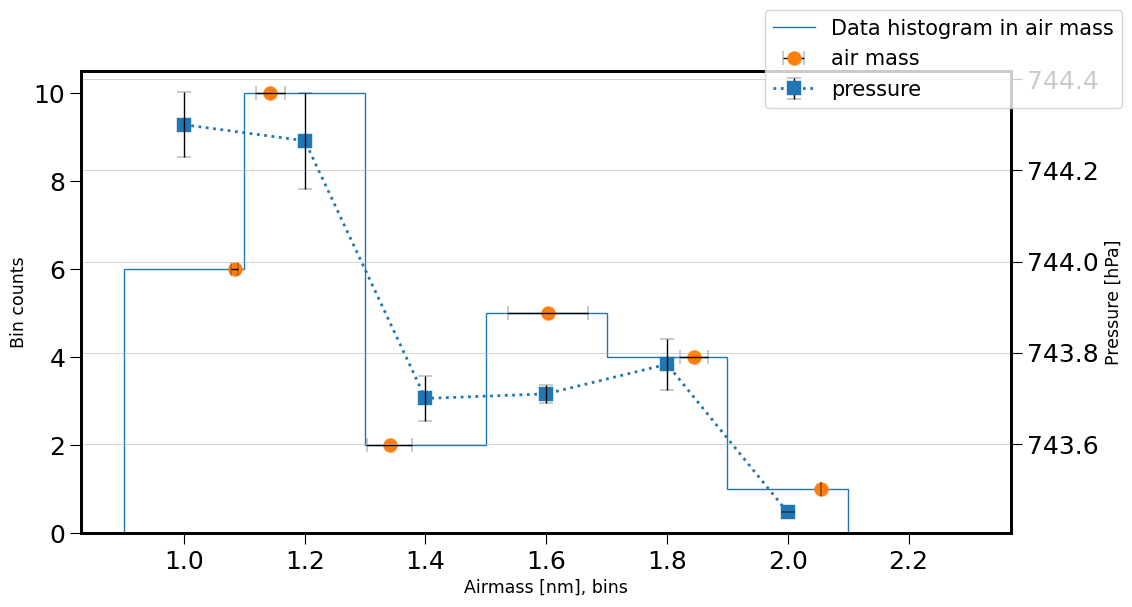

In [11]:
bounds, counts, amMeans, amErrs, pressMeans, pressErrs = bin_data(airmasses, pressures)
print(len(bounds), len(counts), len(amMeans), len(amErrs))
print(bounds, counts)
f,a0 = plt.subplots(1,1)
a1=a0.twinx()
a0.stairs(counts, bounds, label="Data histogram in air mass")
a0.errorbar(amMeans, counts, xerr=amErrs, barsabove=True, ls='', marker='o', label="air mass", ecolor='k', elinewidth=1, capsize=5)
a1.errorbar((bounds[:-1]+bounds[1:])/2, pressMeans, yerr=pressErrs, barsabove=True, ls=':', marker='s', label="pressure", ecolor='k', elinewidth=1, capsize=5)
a1.grid()
a0.set_xlabel("Airmass [nm], bins")
a0.set_ylabel("Bin counts")
a1.set_ylabel("Pressure [hPa]")
f.legend()
#plt.bar((bounds[:-1]+bounds[1:])/2, counts, width=.1)

29
8 7 7 7
[0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3] [6 8 3 2 6 3 1]


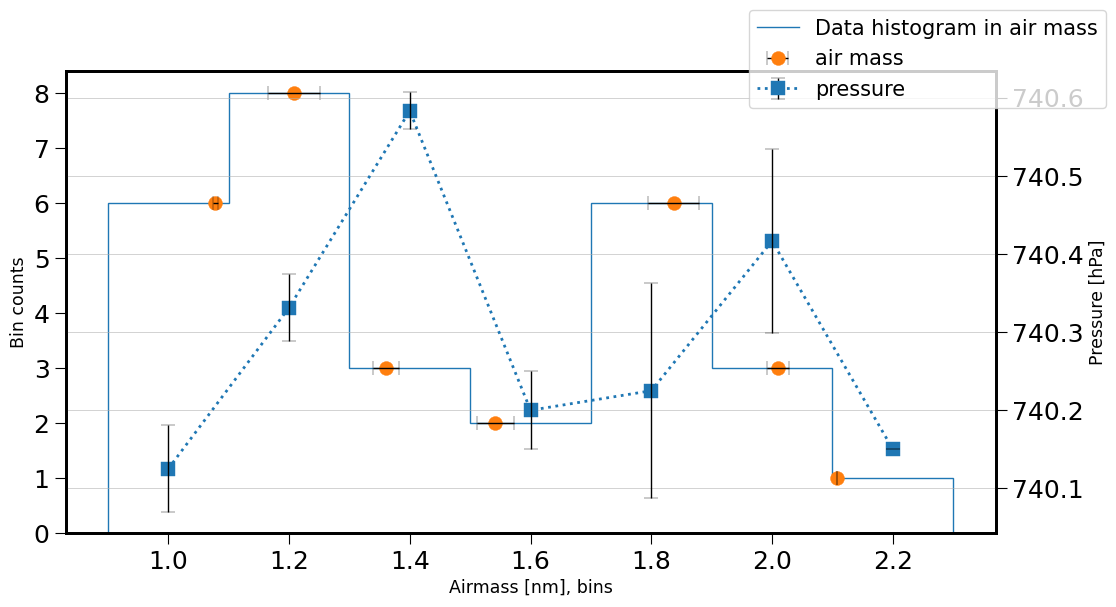

In [12]:
if True:
    ids1, airmasses1, pressures1, eqwidths1, eqw_errs1 = np.loadtxt(os.path.join(outdir,'eqw_data_20220630_FELH0600_holo4_003.txt'), skiprows=1, unpack=True)
    print(len(ids1))
    bounds1, counts1, amMeans1, amErrs1, pressMeans1, pressErrs1 = bin_data(airmasses1, pressures1)
    print(len(bounds1), len(counts1), len(amMeans1), len(amErrs1))
    print(bounds1, counts1)
    f,a0 = plt.subplots(1,1)
    a1=a0.twinx()
    a0.stairs(counts1, bounds1, label="Data histogram in air mass")
    a0.errorbar(amMeans1, counts1, xerr=amErrs1, barsabove=True, ls='', marker='o', label="air mass", ecolor='k', elinewidth=1, capsize=5)
    a1.errorbar((bounds1[:-1]+bounds1[1:])/2, pressMeans1, yerr=pressErrs1, barsabove=True, ls=':', marker='s', label="pressure", ecolor='k', elinewidth=1, capsize=5)
    a1.grid()
    a0.set_xlabel("Airmass [nm], bins")
    a0.set_ylabel("Bin counts")
    a1.set_ylabel("Pressure [hPa]")
    f.legend()
    #plt.bar((bounds[:-1]+bounds[1:])/2, counts, width=.1)

uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/us/sa/lt/in/RT_LS_pp_us_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/us/sa/lt/out/RT_LS_pp_us_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/sw/sa/lt/in/RT_LS_pp_sw_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/sw/sa/lt/out/RT_LS_pp_sw_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/ss/sa/lt/in/RT_LS_pp_ss_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/ss/sa/lt/out/RT_LS_pp_ss_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/ms/sa/lt/in/RT_LS_pp_ms_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3

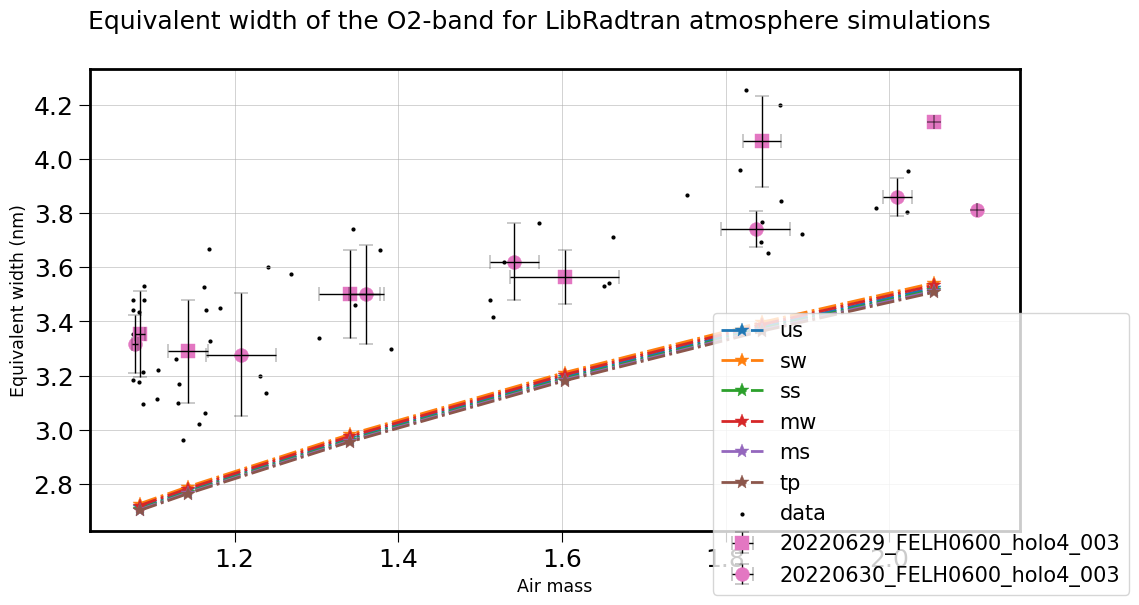

In [13]:
if True:
    fig, ax = plt.subplots(1,1)
    #for p, m in zip([1.0, 2.0, 4.0, 6.0, 8.0], ['*', 'x', '.', '+', '1']):
    atmosEQWS_listOfArrays = simAtmEqw(amMeans[counts>0], pressMeans[counts>0],\
                                       wl_min=min_wl, wl_max=max_wl, wl_mid=h2o_line,\
                                       lims=gaussianLimits, pwv=-1.0, oz=-1.0,\
                                       mod='lt', atm='all', inter='sa', clouds=0.0, flagVerbose=False)
    for atmType,c in zip(atmosEQWS_listOfArrays[0][:,0], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']):
        list_eqw_type = []
        for j in np.arange(len(amMeans[counts>0])):
            list_eqw_type.append(float(atmosEQWS_listOfArrays[j][atmosEQWS_listOfArrays[j][:,0] == atmType, 1][0]))
        #if p == 1.:
            lab=atmType
        #else:
        #    lab=''
        ax.plot(amMeans[counts>0], list_eqw_type, label=lab, ls='-.', marker='*', color=c)
        
    _dum0, _dum1, _dum2, _dum3, eqwMeans, eqwErrs = bin_data(airmasses, eqwidths)
    ax.errorbar(amMeans, eqwMeans, xerr=amErrs, yerr=eqwErrs, barsabove=True,\
                label="20220629_FELH0600_holo4_003", color="tab:pink", ls='', marker="s",\
                ecolor='k', elinewidth=1, capsize=5)
    ax.scatter(airmasses, eqwidths, color='k', marker='.', s=16, label='data')

    
    if True:
        '''
        atmosEQWS_listOfArrays = simAtmEqw(amMeans1[counts1>0], pressMeans1[counts1>0], wl_min=min_wl, wl_max=max_wl, wl_mid=h2o_line, lims=gaussianLimits, pwv=-1.0, oz=-1.0, atm='all', inter='sa', clouds=0.0, flagVerbose=False)
        for atmType,c in zip(atmosEQWS_listOfArrays[0][:,0], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']):
            list_eqw_type = []
            for j in np.arange(len(amMeans1[counts1>0])):
                list_eqw_type.append(float(atmosEQWS_listOfArrays[j][atmosEQWS_listOfArrays[j][:,0] == atmType, 1][0]))
            #if p == 1.:
                lab=''
            #else:
            #    lab=''
            ax.plot(amMeans1[counts1>0], list_eqw_type, label=lab, ls=':', color=c)
        '''
        _dum0, _dum1, _dum2, _dum3, eqwMeans1, eqwErrs1 = bin_data(airmasses1, eqwidths1)
        ax.errorbar(amMeans1, eqwMeans1, xerr=amErrs1, yerr=eqwErrs1, barsabove=True,\
                    label="20220630_FELH0600_holo4_003", color="tab:pink", ls='', marker="o",\
                    ecolor='k', elinewidth=1, capsize=5)
        ax.scatter(airmasses1, eqwidths1, color='k', marker='.', s=16, label='')

        
    ax.set_xlabel("Air mass")
    ax.set_ylabel("Equivalent width (nm)")
    ax.grid()
    fig.legend(loc="lower right")
    fig.suptitle("Equivalent width of the O2-band for LibRadtran atmosphere simulations")

time: 00:21:11
time: 00:21:54
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z20_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z20_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z20_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z20_wv_oz_cld0000.OUT
time: 01:26:22
time: 01:27:05
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.OUT
time: 02:42:58
time: 04:04:31
time: 04:15:06
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec

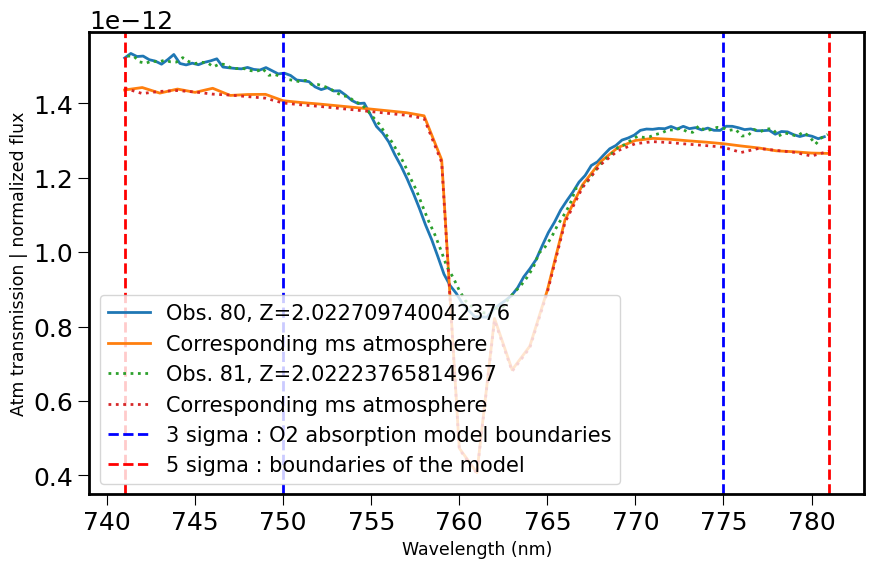

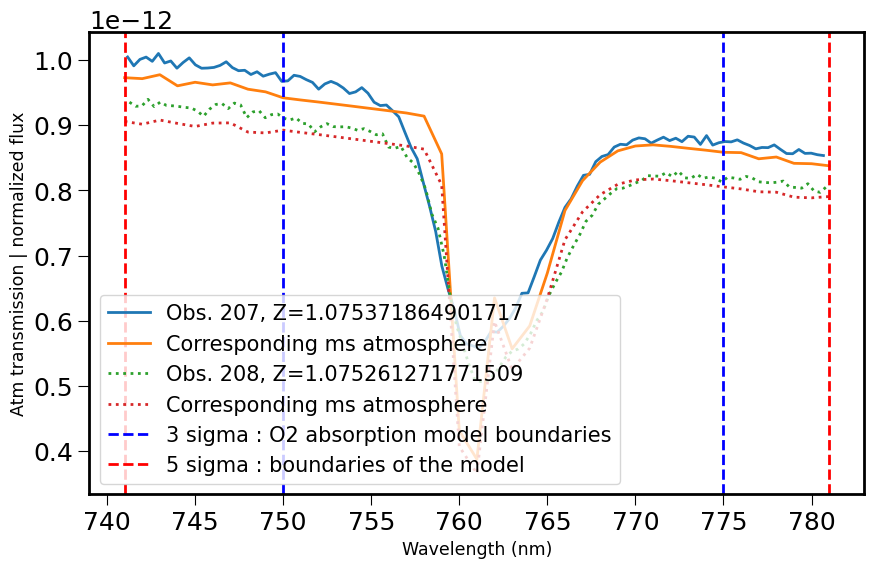

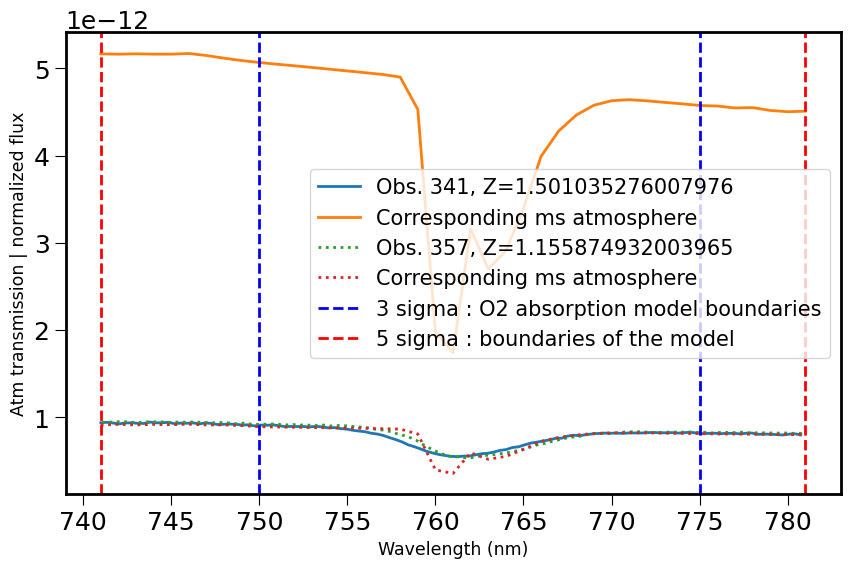

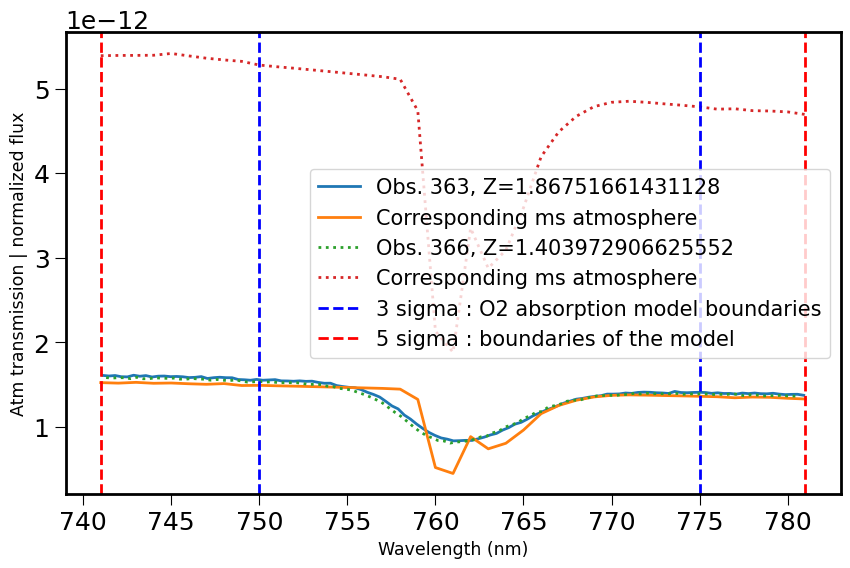

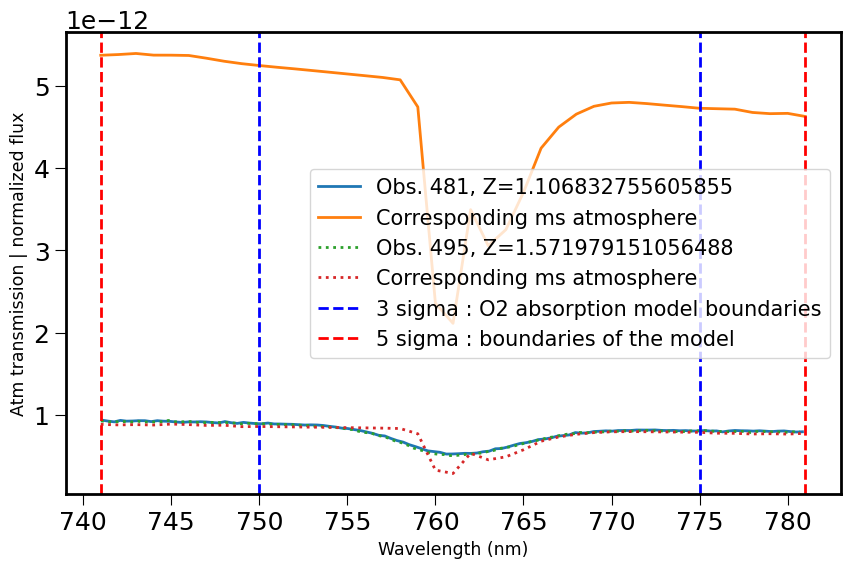

In [14]:
if True:
    for obsId1, obsId2 in [(80, 81), (207, 208), (341, 357), (363, 366), (481, 495)]:#, (505, 506)]:
        sel1, sel2 = np.nonzero(all_numbers == obsId1), np.nonzero(all_numbers == obsId2)
        am1, am2 = all_airmasses[sel1][0], all_airmasses[sel2][0]
        press1, press2 = all_pressures[sel1][0], all_pressures[sel2][0]
        contFunc1, contFunc2 = all_contFunc[sel1][0], all_contFunc[sel2][0]
        lambda_1 = [], []
        flux_2 = [], []
        for obs_date in obs_dates:
            inputfile = os.path.join( inputdir, file_label.format(obs_date, filter_, disperser) )
            with open(inputfile,'rb') as f:
                spec_dict = pickle.load(f)
            bad_spec = bad_spec_dict[obs_date]
            spec_dict_good = {}
            
            for key in spec_dict.keys():
                if int(spec_dict[key]['number']) not in bad_spec:
                    spec_dict_good[key] = spec_dict[key]
            
            for spec in spec_dict_good:
                if int(spec_dict_good[spec]['number']) == obsId1:
                    lambda_1 = spec_dict_good[spec]['all_lambdas']
                    flux_1 = spec_dict_good[spec]['all_fluxes']
                    #print(spec_dict_good[spec].keys())
                    refhour=spec_dict_good[spec]['refhour']
                    hh=np.floor(refhour)
                    mm=np.floor((refhour-hh)*60)
                    ss=((refhour-hh)*60-mm)*60
                    print("time: {:02.0f}:{:02.0f}:{:02.0f}".format(hh, mm, ss))
                elif int(spec_dict_good[spec]['number']) == obsId2:
                    lambda_2 = spec_dict_good[spec]['all_lambdas']
                    flux_2 = spec_dict_good[spec]['all_fluxes']
                    refhour=spec_dict_good[spec]['refhour']
                    hh=np.floor(refhour)
                    mm=np.floor((refhour-hh)*60)
                    ss=((refhour-hh)*60-mm)*60
                    print("time: {:02.0f}:{:02.0f}:{:02.0f}".format(hh, mm, ss))
        
        path1, thefile1 =libsimulateVisible.ProcessSimulation(am1, -1., -1., press1, prof_str='mw',\
                                                            proc_str='sa', cloudext=cloudext)
        theatm1 = np.loadtxt(os.path.join(path1[0],thefile1[0]))
        
        path2, thefile2 =libsimulateVisible.ProcessSimulation(am2, -1., -1., press2, prof_str='mw',\
                                                            proc_str='sa', cloudext=cloudext)
        theatm2 = np.loadtxt(os.path.join(path2[0],thefile2[0]))
        wl1, wl2 = theatm1[:,0], theatm2[:,0]
        trans1, trans2 = theatm1[:,1], theatm2[:,1]
        
        f, a = plt.subplots(1, 1, figsize=(10,6))
        mask_flux1=(lambda_1>=lims[0])*(lambda_1<=lims[-1])
        mask_atm1=(wl1>=lims[0])*(wl1<=lims[-1])
        
        mask_flux2=(lambda_2>=lims[0])*(lambda_2<=lims[-1])
        mask_atm2=(wl2>=lims[0])*(wl2<=lims[-1])
        
        a.plot(lambda_1[mask_flux1], flux_1[mask_flux1], ls="-", label="Obs. {}, Z={}".format(obsId1, am1))
        a.plot(wl1[mask_atm1], contFunc1(wl1[mask_atm1])*trans1[mask_atm1], ls="-", label="Corresponding ms atmosphere")
        a.plot(lambda_2[mask_flux2], flux_2[mask_flux2], ls=":", label="Obs. {}, Z={}".format(obsId2, am2))
        a.plot(wl2[mask_atm2], contFunc2(wl2[mask_atm2])*trans2[mask_atm2], ls=":", label="Corresponding ms atmosphere")
        
        a.axvline(x=lims[1],color='b',ls='--', label="3 sigma : O2 absorption model boundaries")
        a.axvline(x=lims[2],color='b',ls='--')
        a.axvline(x=lims[0],color='r',ls='--', label="5 sigma : boundaries of the model")
        a.axvline(x=lims[3],color='r',ls='--')
        a.legend()
        #a.set_xlim(lims[0], lims[-1])
        #a.set_ylim(0., 1.1)
        a.set_xlabel("Wavelength (nm)")
        a.set_ylabel("Atm transmission | normalized flux")

# Study the atmospheres

In [15]:
logFiles=[]
path0, thefile0=libsimulateVisible.ProcessSimulation(1.0, -1., -1., np.mean(pressMeans[counts>0]), prof_str='all',\
                                                     proc_str='sa', cloudext=cloudext, FLAG_VERBOSE=True)
for path, thefile in zip(path0, thefile0):
    logFiles.append(os.path.join(path, thefile+'_verbose.txt'))

uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/us/sa/lt/in/RT_LS_pp_us_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/us/sa/lt/out/RT_LS_pp_us_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/sw/sa/lt/in/RT_LS_pp_sw_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/sw/sa/lt/out/RT_LS_pp_sw_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/ss/sa/lt/in/RT_LS_pp_ss_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/ss/sa/lt/out/RT_LS_pp_ss_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/mw/sa/lt/in/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.OUT
uvspec cmd:  /home/joseph/libRadtran/bin/uvspec  < simulations/RT/2.0.3/LS/pp/ms/sa/lt/in/RT_LS_pp_ms_sa_lt_z10_wv_oz_cld0000.INP > simulations/RT/2.0.3

In [16]:
len(logFiles)
print(logFiles)

['simulations/RT/2.0.3/LS/pp/us/sa/lt/out/RT_LS_pp_us_sa_lt_z10_wv_oz_cld0000.OUT_verbose.txt', 'simulations/RT/2.0.3/LS/pp/sw/sa/lt/out/RT_LS_pp_sw_sa_lt_z10_wv_oz_cld0000.OUT_verbose.txt', 'simulations/RT/2.0.3/LS/pp/ss/sa/lt/out/RT_LS_pp_ss_sa_lt_z10_wv_oz_cld0000.OUT_verbose.txt', 'simulations/RT/2.0.3/LS/pp/mw/sa/lt/out/RT_LS_pp_mw_sa_lt_z10_wv_oz_cld0000.OUT_verbose.txt', 'simulations/RT/2.0.3/LS/pp/ms/sa/lt/out/RT_LS_pp_ms_sa_lt_z10_wv_oz_cld0000.OUT_verbose.txt', 'simulations/RT/2.0.3/LS/pp/tp/sa/lt/out/RT_LS_pp_tp_sa_lt_z10_wv_oz_cld0000.OUT_verbose.txt']


In [17]:
import subprocess

In [18]:
head = subprocess.run(['head', logFiles[0]])

 ... calling uvspec_check(), checking model input data
*************************************************************************
* When using the LOWTRAN/SBDART gas absorption for any result that goes *
* into a publication, please don't forget to add a reference like:      *
* "Molecular absorption was parameterized with the LOWTRAN band        *
*   model (Pierluissi and Peng, 1985), as adopted from the SBDART code  *
*   (Ricchiazzi et al., 1998).                                          *
*************************************************************************
 ... calling setup_wlgrid(), generating transmittance wavelength grid
 ... using 1051 wavelengths internally


In [19]:
if False:
    def read_atmos(verbose_file):
        num, alt_km, press_hPa, temp_K, air_cm3, oz_cm3, o2_cm3, wv_cm3, co2_cm3, no2_cm3, o4_cm3 =\
        np.empty_like([]), np.empty_like([]), np.empty_like([]), np.empty_like([]), np.empty_like([]), np.empty_like([]),\
        np.empty_like([]), np.empty_like([]), np.empty_like([]), np.empty_like([]), np.empty_like([])

        with open(verbose_file,'r') as logfile:
            atmTable=logfile.readlines()[65:113]
        for line in atmTable:
            vals=line.split()
            num=np.append(num,float(vals[0]))
            alt_km=np.append(alt_km, float(vals[1]))
            press_hPa=np.append(press_hPa, float(vals[2]))
            temp_K=np.append(temp_K, float(vals[3]))
            air_cm3=np.append(air_cm3, float(vals[4]))
            oz_cm3=np.append(oz_cm3, float(vals[5]))
            o2_cm3=np.append(o2_cm3, float(vals[6]))
            wv_cm3=np.append(wv_cm3, float(vals[7]))
            co2_cm3=np.append(co2_cm3, float(vals[8]))
            no2_cm3=np.append(no2_cm3, float(vals[9]))
            o4_cm3=np.append(o4_cm3, float(vals[10]))
        d = {'Number': num,\
            'Altitude': alt_km,\
            'Pressure': press_hPa,\
            'Temperature': temp_K,\
            'Air density': air_cm3,\
            'Ozone density': oz_cm3,\
            'Dioxygene density': o2_cm3,\
            'Water vapor density': wv_cm3,\
            'Carbon dioxyde density': co2_cm3,\
            'Azote dioxyde density': no2_cm3,\
            'Oxozone density': o4_cm3}
        atmos = pd.DataFrame(data=d)
        return atmos

In [20]:
atmos_pd=read_atm(logFiles[0], 66, 113) #rtvis, coarse : 2627, 2674 ; lt : 66, 113
atmos_pd

,Number,Altitude,Pressure,Temperature,Air density,Ozone density,Dioxygene density,Water vapor density,Carbon dioxyde density,Azote dioxyde density,Oxozone density
0,0.0,120.00,0.00003,360.00,5.253700e+11,2.557000e+02,3.811720e+10,1.022800e+05,1.840140e+07,7.722140e+01,1.374670e-25
1,1.0,115.00,0.00004,300.00,9.953060e+11,4.844000e+03,9.362330e+10,2.325120e+05,3.983970e+07,1.501640e+02,8.293240e-25
2,2.0,110.00,0.00007,240.00,2.202830e+12,1.072000e+05,2.645010e+11,6.003200e+05,1.322510e+08,3.408960e+02,6.619300e-24
3,3.0,105.00,0.00014,208.80,5.170960e+12,1.006600e+06,7.243970e+11,1.711220e+06,5.691690e+08,8.254120e+02,4.964890e-23
4,4.0,100.00,0.00033,195.10,1.221310e+13,4.756000e+06,1.955800e+12,4.756000e+06,2.383630e+09,2.021300e+03,3.619130e-22
5,5.0,95.00,0.00078,188.40,3.003770e+13,2.046800e+07,5.410930e+12,1.578960e+07,8.116390e+09,5.146240e+03,2.770130e-21
6,6.0,90.00,0.00189,186.90,7.330650e+13,4.995200e+07,1.393900e+13,6.065600e+07,2.274250e+10,1.305890e+04,1.838300e-20
7,7.0,85.00,0.00459,188.90,1.758070e+14,8.555000e+07,3.518050e+13,2.275630e+08,5.628880e+10,3.285120e+04,1.171010e-19
8,8.0,80.00,0.01079,198.60,3.936800e+14,1.149600e+08,8.233670e+13,7.855600e+08,1.292170e+11,7.740640e+04,6.414210e-19
9,9.0,75.00,0.02467,208.40,8.575260e+14,2.086750e+08,1.793490e+14,2.358030e+09,2.831820e+11,1.794600e+05,3.043360e-18


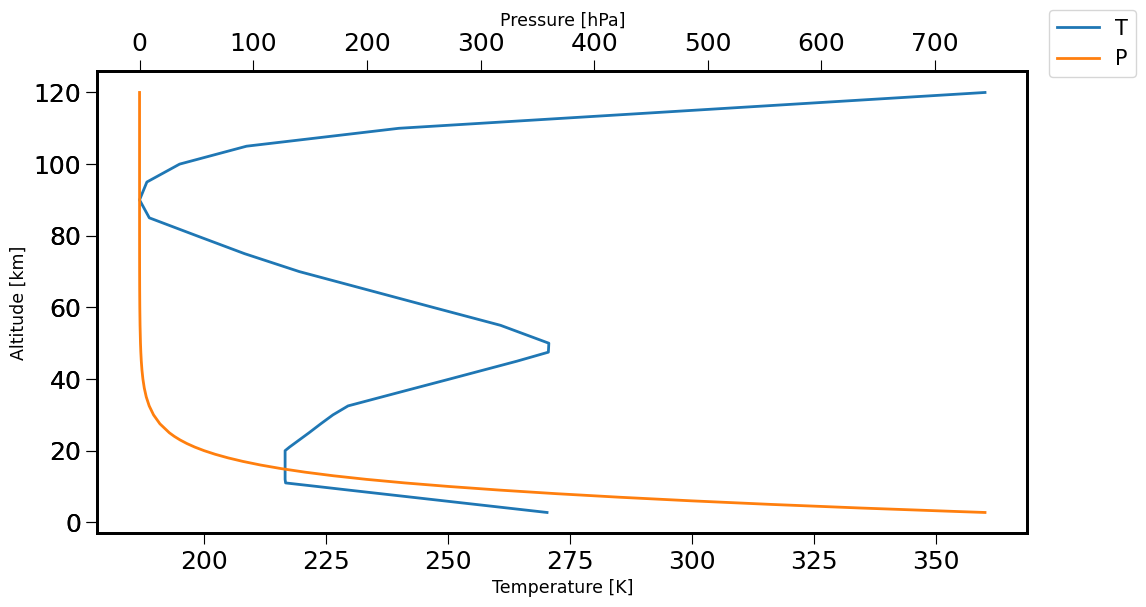

In [21]:
fig, ax = plt.subplots(1,1)
atmos_pd.plot(x='Temperature', y='Altitude', label="T", ax=ax,\
              xlabel='Temperature [K]', ylabel='Altitude [km]', color="tab:blue", legend=False)
ax1=ax.twiny()
atmos_pd.plot(x='Pressure', y='Altitude', label='P', ax=ax1,\
              xlabel='Pressure [hPa]', color="tab:orange", legend=False)
fig.legend()

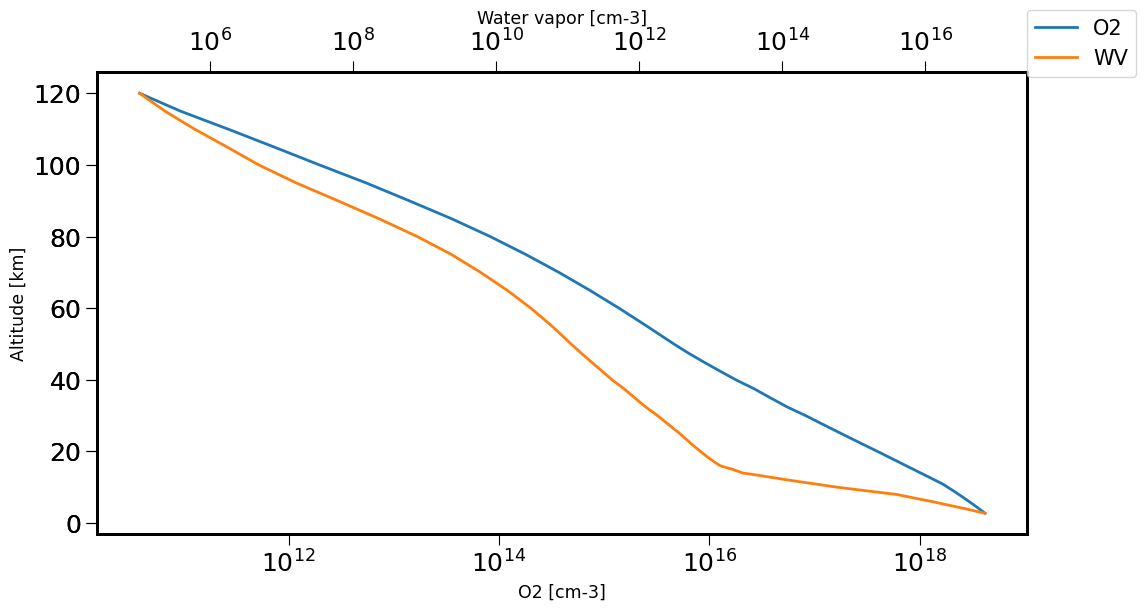

In [22]:
fig, ax = plt.subplots(1,1)
atmos_pd.plot(x='Dioxygene density', y='Altitude', logx=True, label="O2", ax=ax,\
              xlabel='O2 [cm-3]', ylabel='Altitude [km]', color="tab:blue", legend=False)
ax1=ax.twiny()
atmos_pd.plot(x='Water vapor density', y='Altitude', logx=True, label='WV',ax=ax1,\
              xlabel='Water vapor [cm-3]', color="tab:orange", legend=False)
fig.legend()

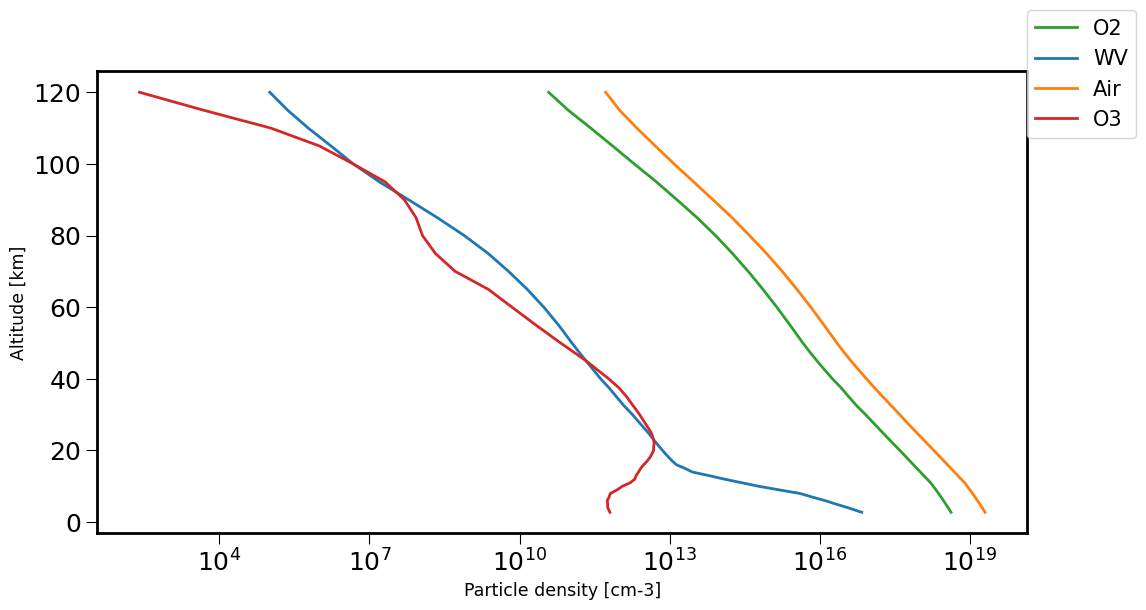

In [23]:
fig, ax = plt.subplots(1,1)
atmos_pd.plot(x='Dioxygene density', y='Altitude', logx=True, label="O2", ax=ax,\
              xlabel='Particle density [cm-3]', ylabel='Altitude [km]', color="tab:green", legend=False)
atmos_pd.plot(x='Water vapor density', y='Altitude', logx=True, label='WV',ax=ax,\
              xlabel='Particle density [cm-3]', color="tab:blue", legend=False)
atmos_pd.plot(x='Air density', y='Altitude', logx=True, label='Air',ax=ax,\
              xlabel='Particle density [cm-3]', color="tab:orange", legend=False)
atmos_pd.plot(x='Ozone density', y='Altitude', logx=True, label='O3',ax=ax,\
              xlabel='Particle density [cm-3]', color="tab:red", legend=False)
fig.legend()

us
sw
ss
mw
ms
tp


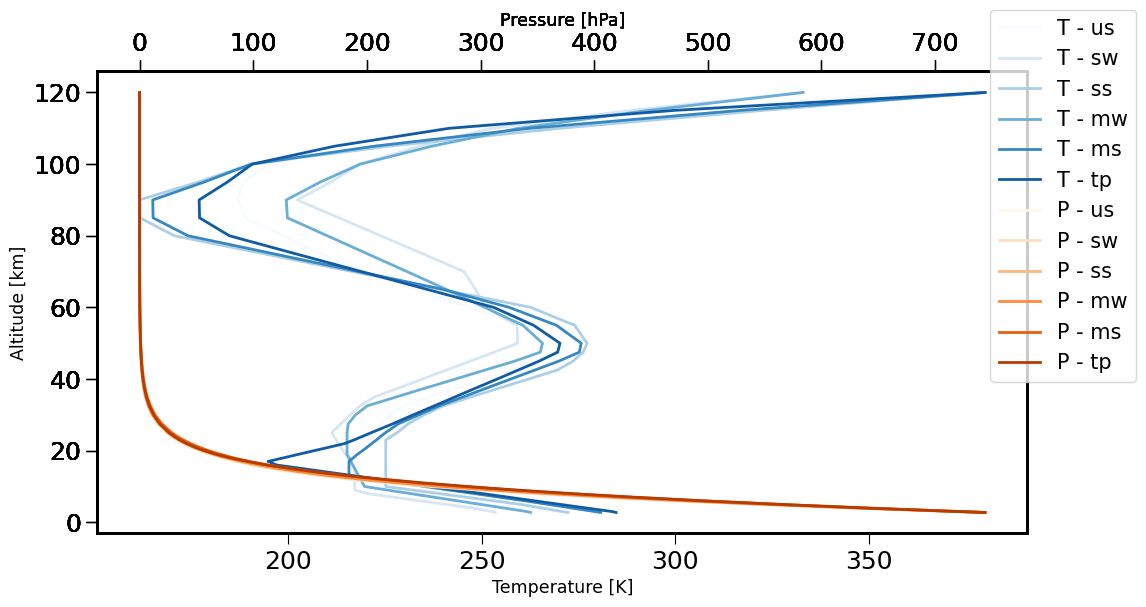

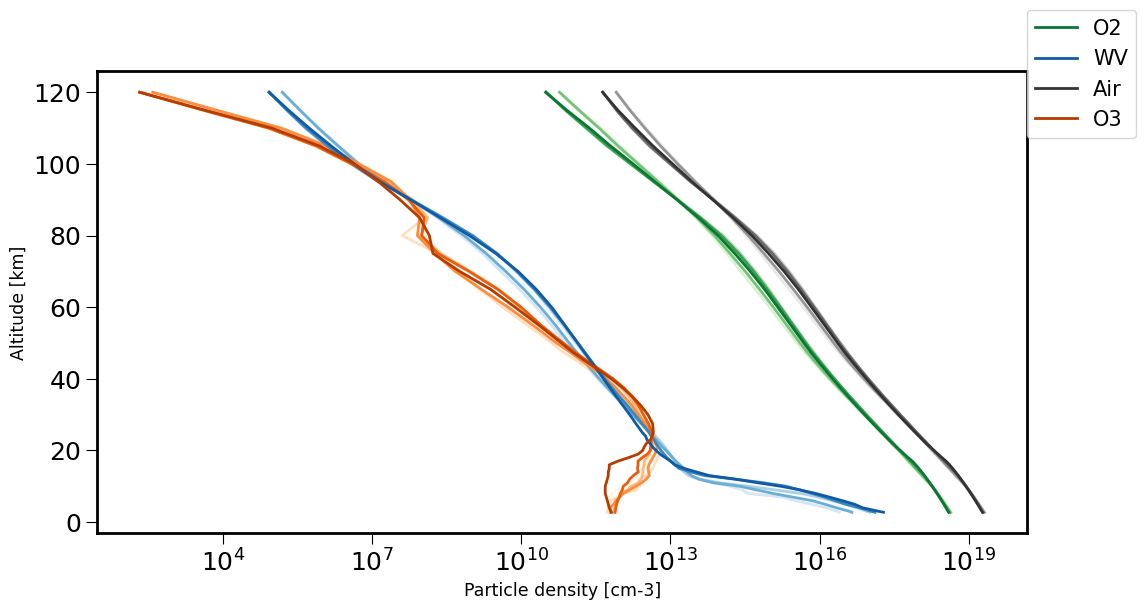

In [24]:
bluesMap = plt.get_cmap('Blues')
greysMap = plt.get_cmap('Greys')
greensMap = plt.get_cmap('Greens')
orangesMap = plt.get_cmap('Oranges')
atmList=[]
for log in logFiles:
    atmType = log.split('/')[-5]
    atmList.append(atmType)
    
cNorm = colors.Normalize(vmin=0, vmax=len(atmList))
scalBluesMap = cmx.ScalarMappable(norm=cNorm, cmap=bluesMap)
scalGreysMap = cmx.ScalarMappable(norm=cNorm, cmap=greysMap)
scalGreensMap = cmx.ScalarMappable(norm=cNorm, cmap=greensMap)
scalOrangesMap = cmx.ScalarMappable(norm=cNorm, cmap=orangesMap)
all_blues = scalBluesMap.to_rgba(np.arange(len(atmList)), alpha=1)
all_greys = scalGreysMap.to_rgba(np.arange(len(atmList)), alpha=1)
all_greens = scalGreensMap.to_rgba(np.arange(len(atmList)), alpha=1)
all_oranges = scalOrangesMap.to_rgba(np.arange(len(atmList)), alpha=1)

f1, a1 = plt.subplots(1,1)
f2, a2 = plt.subplots(1,1)

for log, atm, idx in zip(logFiles, atmList, np.arange(len(atmList))):
    print(atm)
    atmos_pd=read_atm(log, 66, 113) #rtvis, coarse : 2627, 2674 ; lt : 66, 113 
    
    atmos_pd.plot(x='Temperature', y='Altitude', label="T - "+atm, ax=a1,\
                  xlabel='Temperature [K]', ylabel='Altitude [km]', color=all_blues[idx], legend=False)
    a11=a1.twiny()
    atmos_pd.plot(x='Pressure', y='Altitude', label='P - '+atm, ax=a11,\
                  xlabel='Pressure [hPa]', color=all_oranges[idx], legend=False)
    if idx==len(atmList)-1:
        atmos_pd.plot(x='Dioxygene density', y='Altitude', logx=True, label="O2", ax=a2,\
                      xlabel='Particle density [cm-3]', ylabel='Altitude [km]', color=all_greens[idx], legend=False)
        atmos_pd.plot(x='Water vapor density', y='Altitude', logx=True, label='WV',ax=a2,\
                      xlabel='Particle density [cm-3]', color=all_blues[idx], legend=False)
        atmos_pd.plot(x='Air density', y='Altitude', logx=True, label='Air',ax=a2,\
                      xlabel='Particle density [cm-3]', color=all_greys[idx], legend=False)
        atmos_pd.plot(x='Ozone density', y='Altitude', logx=True, label='O3',ax=a2,\
                      xlabel='Particle density [cm-3]', color=all_oranges[idx], legend=False)
    else:
        atmos_pd.plot(x='Dioxygene density', y='Altitude', logx=True, label='', ax=a2,\
                      xlabel='Particle density [cm-3]', ylabel='Altitude [km]', color=all_greens[idx], legend=False)
        atmos_pd.plot(x='Water vapor density', y='Altitude', logx=True, label='',ax=a2,\
                      xlabel='Particle density [cm-3]', color=all_blues[idx], legend=False)
        atmos_pd.plot(x='Air density', y='Altitude', logx=True, label='',ax=a2,\
                      xlabel='Particle density [cm-3]', color=all_greys[idx], legend=False)
        atmos_pd.plot(x='Ozone density', y='Altitude', logx=True, label='',ax=a2,\
                      xlabel='Particle density [cm-3]', color=all_oranges[idx], legend=False)
f1.legend()
f2.legend()